# Importação e preparação dos dados

In [1]:
import pandas as pd

df = pd.read_csv('../dados/jurisprudencia_selecionada_enunciados.csv', sep = '|')
df.head()

,COD,NUM_ENUNCIADO,COD_AREA,DESCR_AREA,COD_TEMA,DESCR_TEMA,COD_SUBTEMA,DESCR_SUBTEMA,COD_DOC_TRAMITAVEL_ENUNCIADO,TEXTO_ENUNCIADO,ACORDAO,TIPO_PROCESSO
0,1400,1236,50,Responsabilidade,488,Solidariedade,261,Benefício previdenciário,54995437,Não comprovada a participação do beneficiário ...,Acórdão 297/2016 - PL,Tomada de Contas Especial
1,1700,1534,46,Finanças Públicas,981,Exportação,983,Petróleo,55025587,A operação ficta de exportação de plataformas ...,Acórdão 366/2016 - PL,Solicitação do Congresso Nacional
2,5700,5314,50,Responsabilidade,203,Multa,1021,Dosimetria,55455370,"No âmbito do TCU, a dosimetria da pena tem com...",Acórdão 944/2016 - PL,Acompanhamento
3,284,40,45,Direito Processual,162,Princípio da independência das instâncias,481,Decisão judicial,54773746,O princípio da independência das instâncias pe...,Acórdão 30/2016 - PL,Tomada de Contas Especial
4,298,54,49,Pessoal,141,Sistema S,142,Nepotismo,54773402,É vedado aos dirigentes das entidades do Siste...,Acórdão 55/2016 - PL,Representação


In [2]:
df.shape

(13312, 12)

In [3]:
from sklearn.preprocessing import LabelBinarizer

areas = df.groupby(['DESCR_AREA']).groups.keys()
lbArea = LabelBinarizer()
lbArea.fit([x for x in areas])
y = lbArea.transform(df['DESCR_AREA'])
y.shape

(13312, 10)

In [4]:
from keras.preprocessing.text import Tokenizer
import numpy as np

vocabulario = 20000
limite_texto = 200
dim_vetor = 100

tokenizer = Tokenizer(num_words=vocabulario)
tokenizer.fit_on_texts(df['TEXTO_ENUNCIADO'])

sequences = tokenizer.texts_to_sequences(df['TEXTO_ENUNCIADO'])

word_index = tokenizer.word_index
vocabulario = len(word_index) + 1
print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Found 15387 unique tokens.


In [5]:
from keras.preprocessing.sequence import pad_sequences

x = pad_sequences(sequences, maxlen=limite_texto)

print('Shape of data tensor:', x.shape)

Shape of data tensor: (13312, 200)


In [7]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('../externos/model.txt')

In [8]:
# create a weight matrix for words in training docs

embedding_matrix = np.zeros((vocabulario, dim_vetor))

ok = 0
for word, i in tokenizer.word_index.items():
    if word in model:
        embedding_matrix[i] = model[word]
        ok += 1
print('Vocabulario:', i)
print('Encontrados no modelo:', ok, '=', ok * 100. / i)

Vocabulario: 15387
Encontrados no modelo: 13758 = 89.41314096315071


In [9]:
x.shape, y.shape

((13312, 200), (13312, 10))

# Treinamento

In [10]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, GlobalMaxPooling1D
from keras.optimizers import RMSprop

model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, weights=[embedding_matrix], input_length=limite_texto, trainable=False))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(),  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

W1130 16:37:28.986351 139749892589376 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1130 16:37:29.117938 139749892589376 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1130 16:37:29.119641 139749892589376 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1130 16:37:29.127230 139749892589376 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprec

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          1538800   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 194, 32)           22432     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 38, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 1,568,762
Trainable params: 29,962
Non-trainable params: 1,538,800
_____________________________________________________________

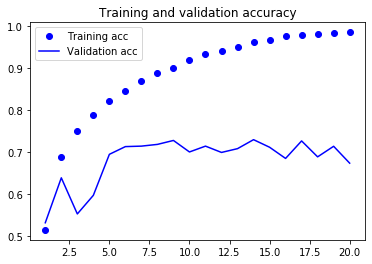

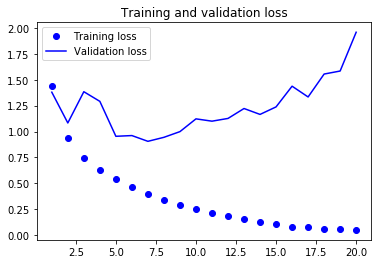

In [12]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, weights=[embedding_matrix], input_length=limite_texto, trainable=True))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(),  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 100)          1538800   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 194, 32)           22432     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 38, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 32, 32)            7200      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 1,568,762
Trainable params: 1,568,762
Non-trainable params: 0
_________________________________________________________________


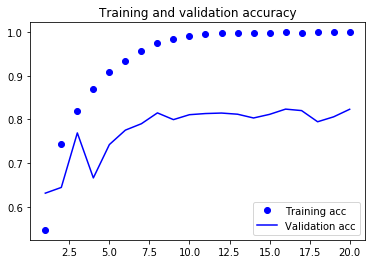

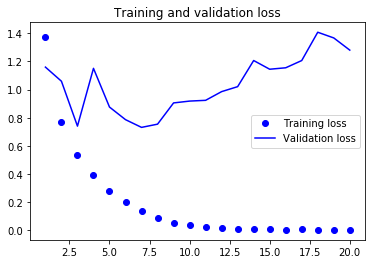

In [14]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, weights=[embedding_matrix], input_length=limite_texto, trainable=True))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=5e-3),  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 100)          1538800   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 194, 32)           22432     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 38, 32)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 32, 32)            7200      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 1,568,762
Trainable params: 1,568,762
Non-trainable params: 0
_________________________________________________________________


In [17]:
from keras.layers import GRU

model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, weights=[embedding_matrix], input_length=limite_texto, trainable=True))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GRU(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(),  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 100)          1538800   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 194, 32)           22432     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 38, 32)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 32, 32)            7200      
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
Total params: 1,575,002
Trainable params: 1,575,002
Non-trainable params: 0
_________________________________________________________________


In [18]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, weights=[embedding_matrix], input_length=limite_texto, trainable=True))
model.add(Conv1D(64, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(),  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 100)          1538800   
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 194, 64)           44864     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 38, 64)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 32, 32)            14368     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                330       
Total params: 1,598,362
Trainable params: 1,598,362
Non-trainable params: 0
_________________________________________________________________


In [20]:
from keras.layers import Flatten
from keras.layers.core import Dropout

model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, weights=[embedding_matrix], input_length=limite_texto, trainable=True))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(),  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 200, 100)          1538800   
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 194, 32)           22432     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 38, 32)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1216)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               311552    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                2570      
Total para

In [21]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, weights=[embedding_matrix], input_length=limite_texto, trainable=True))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(),  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 200, 100)          1538800   
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 194, 32)           22432     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 38, 32)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 32, 32)            7200      
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_10 (Dense)             (None, 10)                330       
Total params: 1,575,002
Trainable params: 1,575,002
Non-trainable params: 0
_________________________________________________________________


In [22]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, weights=[embedding_matrix], input_length=limite_texto, trainable=True))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GRU(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(),  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 200, 100)          1538800   
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 194, 32)           22432     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 38, 32)            0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 32, 32)            7200      
_________________________________________________________________
gru_4 (GRU)                  (None, 64)                18624     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                650       
Total params: 1,587,706
Trainable params: 1,587,706
Non-trainable params: 0
_________________________________________________________________
